<a href="https://colab.research.google.com/github/akash-agni/DeepLearning/blob/main/Car_Type_Object_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download -d jessicali9530/stanford-cars-dataset

100% 1.82G/1.82G [00:20<00:00, 125MB/s]
100% 1.82G/1.82G [00:20<00:00, 94.3MB/s]


In [3]:
! mkdir ./data
! unzip stanford-cars-dataset.zip -d ./data > extract.log
! rm -rf stanford-cars-dataset.zip

In [166]:
import os, time
import numpy as np
import torch
import pandas as pd
from PIL import Image
from scipy.io import loadmat

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn import metrics as mtr

import torch
from torchvision.transforms import ToTensor

In [189]:
class cars_data:

  def __init__(self, root, split, transforms=None):
    self.data_dir = None
    assert split in ['train', 'test']
    
    if split == 'train':
      self.data_dir = os.path.join(root, 'cars_train', 'cars_train')
    elif split == 'test':
      self.data_dir = os.path.join(root, 'cars_test', 'cars_test')
    self.imgs = list(sorted(os.listdir(self.data_dir)))

    label_file = os.path.join(root, 'cars_annos.mat')
    annot = loadmat(label_file)['annotations'][0]
    self.label_data = pd.DataFrame([[i.flat[0] for i in line] for line in annot])
    self.label_data.columns = ['fname', 'x1', 'x2', 'y1', 'y2', 'class', 'split']
    self.label_data['fname'] = self.label_data['fname'].apply(lambda x : x.split('/')[1][1:])

    self.classes = loadmat(label_file)['class_names'][0]
    #self.classes = [i.flat[0] for i in self.classes]

    self.transforms = transforms
  
  def __len__(self):
    return len(self.imgs)
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.data_dir, self.imgs[idx])
    img = np.array(Image.open(img_path).convert('RGB'), dtype=np.float32)
    img = img/255.0
    boxes = list()
    labels = list()
    ld = np.array(self.label_data[self.label_data['fname'] == self.imgs[idx]])
    for row in ld:
      xmin = float(row[1])
      xmax = float(row[3])
      ymin = float(row[2])
      ymax = float(row[4])
      boxes.append([xmin, xmax, ymin, ymax])
      labels.append(row[5])
    
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = dict()
    target['boxes'] = boxes
    target['labels'] = labels

    if self.transforms is not None:
      img = self.transforms(img)

    return img, target

    

In [190]:
train_data = cars_data("/content/data", 'train')
test_data = cars_data("/content/data", 'test')

In [191]:
item[1]['boxes']

tensor([[112., 853.,   7., 717.]])

(441.0, 48.0) -178.0 393.0


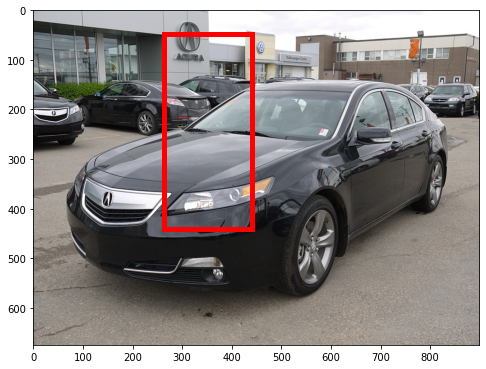

In [214]:
item = train_data[1]
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(item[0])
item = np.array(item[1]['boxes'])
xy = (item[0,1], item[0,0])
h = item[0,2] - item[0,3]
w = item[0,1] - item[0,0]
print(xy, h, w)
rec = patches.Rectangle(xy, h, w, linewidth=5, edgecolor='r', facecolor='none')
ax.add_patch(rec)
plt.show()

In [154]:
train_data.classes[0]

array(['AM General Hummer SUV 2000'], dtype='<U26')

In [202]:
loadmat("/content/data/cars_annos.mat")['annotations']

array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        ...,
        (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uint16), array([[196]], dtype=uint8), array([[1]], dtype=uint8)),
        (array(['car_ims/016184.jpg'], dtype='<U18'), array([[56]], dtype=uint8), array([

In [209]:
np.array(Image.open('/content/data/cars_train/cars_train/00001.jpg')).shape

(400, 600, 3)

In [10]:
! wget "http://imagenet.stanford.edu/internal/car196/cars_train.tgz"

--2021-03-26 20:43:28--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz.1’

cars_train.tgz.1      2%[                    ]  26.62M  1.89MB/s    eta 6m 58s ^C


In [2]:
import tensorflow_datasets as tfds